## Notebook to Replicate Mouse Brain Sagittal Anterior results (Fig S2, S6)
#### Landmark distance  

---

**Author:** Benedetta Manzato  
**Date:** 30 October 2025

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import pandas as pd
from scipy.spatial import cKDTree, distance, KDTree
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
import anndata as ad
import scikit_posthocs as sp
import itertools
import scanpy as sc
from collections import Counter

import warnings
warnings.filterwarnings("ignore")

ds = 'Mouse_Brain_Sagittal_Anterior_10X'
wd = f'/exports/humgen/bmanzato/valid_data/{ds}'
benchmark_dir = '/exports/humgen/bmanzato/benchmark'

### Landmark validation

#### Read landmarks csv and tile-centroid file 

In [2]:
landmarks = pd.read_csv(f"{wd}/landmarks/landmarks.csv", index_col=0, header=None)
landmarks.columns = ['TF', 'query_x', 'query_y', 'ref_x', 'ref_y']  
    
# Read ViT data
vit_coord_1 = pd.read_csv(f"{wd}/ViT/ViT_coord_1_224.csv", index_col=0)
vit_coord_2 = pd.read_csv(f"{wd}/ViT/ViT_coord_2_224.csv", index_col=0)

vit_coord_1.index = vit_coord_1.index.astype(str) + '_s1'
vit_coord_2.index = vit_coord_2.index.astype(str) + '_s2'

vit_coord_1_filt = vit_coord_1[~vit_coord_1.index.str.endswith("_outside_s1")]
vit_coord_2_filt = vit_coord_2[~vit_coord_2.index.str.endswith("_outside_s2")]

# Map the closest index to the landmarks -- img 2
tree = cKDTree(vit_coord_2_filt[['x', 'y']].values)
_, indices = tree.query(landmarks[['ref_x', 'ref_y']].values, k=1)
landmarks['closest_point_ref'] = vit_coord_2_filt.index[indices]

# Map the closest index to the landmarks -- img 1
tree = cKDTree(vit_coord_1_filt[['x', 'y']].values)
_, indices = tree.query(landmarks[['query_x', 'query_y']].values, k=1)
landmarks['closest_point_query'] = vit_coord_1_filt.index[indices]

#### Read aligned files for (1) COAST, (2) Rigid Alignment, (3) Unaligned, (4) CAST

In [3]:
# Read aligned coordinates for COAST
coordfinal_1 = pd.read_csv(f"{wd}/coord_final/coord_final_section1_stack_224.csv", index_col=0)
coordfinal_1.index = vit_coord_1.index
coordfinal_1_filt = coordfinal_1[~coordfinal_1.index.str.endswith("_outside_s1")]
# Map new coordinates
landmarks['COAST_aligned_stack_x'] = landmarks['closest_point_query'].map(coordfinal_1_filt['0'])
landmarks['COAST_aligned_stack_y'] = landmarks['closest_point_query'].map(coordfinal_1_filt['1'])


# Read aligned coordinates for RA
coordfinal_1_ra = pd.read_csv(f"{benchmark_dir}/Rigid_Alignment/{ds}/RA_section1_aligned.csv", index_col=0)
coordfinal_1_ra.columns = ['x', 'y']
coordfinal_1_ra.index = vit_coord_1_filt.index
# Map new coordinates
landmarks['RA_aligned_x'] = landmarks['closest_point_query'].map(coordfinal_1_ra['x'])
landmarks['RA_aligned_y'] = landmarks['closest_point_query'].map(coordfinal_1_ra['y'])


# Read aligned coordinates for Unaligned
coordfinal_1_no = vit_coord_1_filt
coordfinal_1_no.columns = ['x', 'y']
coordfinal_1_no.index = vit_coord_1_filt.index
# Map new coordinates
landmarks['NO_aligned_x'] = landmarks['closest_point_query'].map(coordfinal_1_no['x'])
landmarks['NO_aligned_y'] = landmarks['closest_point_query'].map(coordfinal_1_no['y'])


# Read aligned coordinates for CAST
coordfinal_1_cast = pd.read_csv(f"{benchmark_dir}/CAST/{ds}/output/coord_final_section1_raw.csv", index_col=0)
coordfinal_1_cast.columns = ['x', 'y']
coordfinal_1_cast.index = vit_coord_1_filt.index
# Map new coordinates
landmarks['CAST_aligned_x'] = landmarks['closest_point_query'].map(coordfinal_1_cast['x'])
landmarks['CAST_aligned_y'] = landmarks['closest_point_query'].map(coordfinal_1_cast['y'])

#### Read aligned files for (5) MOSCOT

For MOSCOT we need to identify an offset for x and y for which the coordinates have been translated in the alignment step

In [4]:
coordfinal_2_moscot = ad.read_h5ad(f"{benchmark_dir}/MOSCOT/{ds}/output/sec2_affinecoord_raw.h5ad")
coordfinal_2_moscot.obs['offset_x'] = coordfinal_2_moscot.obs['affine-x'] - coordfinal_2_moscot.obs['x']
coordfinal_2_moscot.obs['offset_y'] = coordfinal_2_moscot.obs['affine-y'] - coordfinal_2_moscot.obs['y']
coordfinal_2_moscot.obs.head()

,in_tissue,array_row,array_col,y,x,section,affine-x,affine-y,offset_x,offset_y
AAACAAGTATCTCCCA-1,1,50,102,7608,8599,section2,2049.543039,1275.584485,-6549.456961,-6332.415515
AAACACCAATAACTGC-1,1,59,19,8686,2886,section2,-3663.456961,2353.584485,-6549.456961,-6332.415515
AAACAGAGCGACTCCT-1,1,14,94,3297,8048,section2,1498.543039,-3035.415515,-6549.456961,-6332.415515
AAACAGCTTTCAGAAG-1,1,43,9,6770,2198,section2,-4351.456961,437.584485,-6549.456961,-6332.415515
AAACAGGGTCTATATT-1,1,47,13,7249,2473,section2,-4076.456961,916.584485,-6549.456961,-6332.415515


In [5]:
# Read aligned coordinates for MOSCOT
coordfinal_1_moscot = ad.read_h5ad(f"{benchmark_dir}/MOSCOT/{ds}/output/sec1_affinecoord_raw.h5ad")
coordfinal_1_moscot = coordfinal_1_moscot.obs[['affine-x', 'affine-y']]
coordfinal_1_moscot.columns = ['x','y']

coordfinal_1_moscot['x'] = coordfinal_1_moscot['x']-coordfinal_2_moscot.obs['offset_x']
coordfinal_1_moscot['y'] = coordfinal_1_moscot['y']-coordfinal_2_moscot.obs['offset_y']

coordfinal_1_moscot.index = vit_coord_1_filt.index
# Map new coordinates
landmarks['MOSCOT_aligned_x'] = landmarks['closest_point_query'].map(coordfinal_1_moscot['x'])
landmarks['MOSCOT_aligned_y'] = landmarks['closest_point_query'].map(coordfinal_1_moscot['y'])

#### Calculate Euclidean distances

In [6]:
landmarks['COAST_distance'] = np.sqrt((landmarks['ref_x'] - landmarks['COAST_aligned_stack_x'])**2 +
                                            (landmarks['ref_y'] - landmarks['COAST_aligned_stack_y'])**2)
landmarks['Unalig_distance'] = np.sqrt((landmarks['ref_x'] - landmarks['NO_aligned_x'])**2 +
                                       (landmarks['ref_y'] - landmarks['NO_aligned_y'])**2)
landmarks['RA_distance'] = np.sqrt((landmarks['ref_x'] - landmarks['RA_aligned_x'])**2 +
                                       (landmarks['ref_y'] - landmarks['RA_aligned_y'])**2)
landmarks['CAST_distance'] = np.sqrt((landmarks['ref_x'] - landmarks['CAST_aligned_x'])**2 +
                                       (landmarks['ref_y'] - landmarks['CAST_aligned_y'])**2)
landmarks['MOSCOT_distance'] = np.sqrt((landmarks['ref_x'] - landmarks['MOSCOT_aligned_x'])**2 +
                                       (landmarks['ref_y'] - landmarks['MOSCOT_aligned_y'])**2)
# Drop NaN values
landmarks_clean = landmarks[['COAST_distance', 'Unalig_distance', 'RA_distance','CAST_distance','MOSCOT_distance']].dropna()

landmarks_clean.head()

,COAST_distance,Unalig_distance,RA_distance,CAST_distance,MOSCOT_distance
0,,,,,
Pt-0,147.207979,784.506580,330.720114,167.720816,200.335074
Pt-1,96.862549,746.031558,287.715328,201.763739,153.839530
Pt-2,92.563716,862.633623,429.361501,128.080072,270.899482
Pt-3,135.294159,709.569732,238.243919,259.672872,146.175849
Pt-4,168.812642,565.888097,270.800700,119.435608,2.460796


#### Boxplot landmark distances per method

One-way ANOVA: p=0.00000
Overall p-value: 0.00000


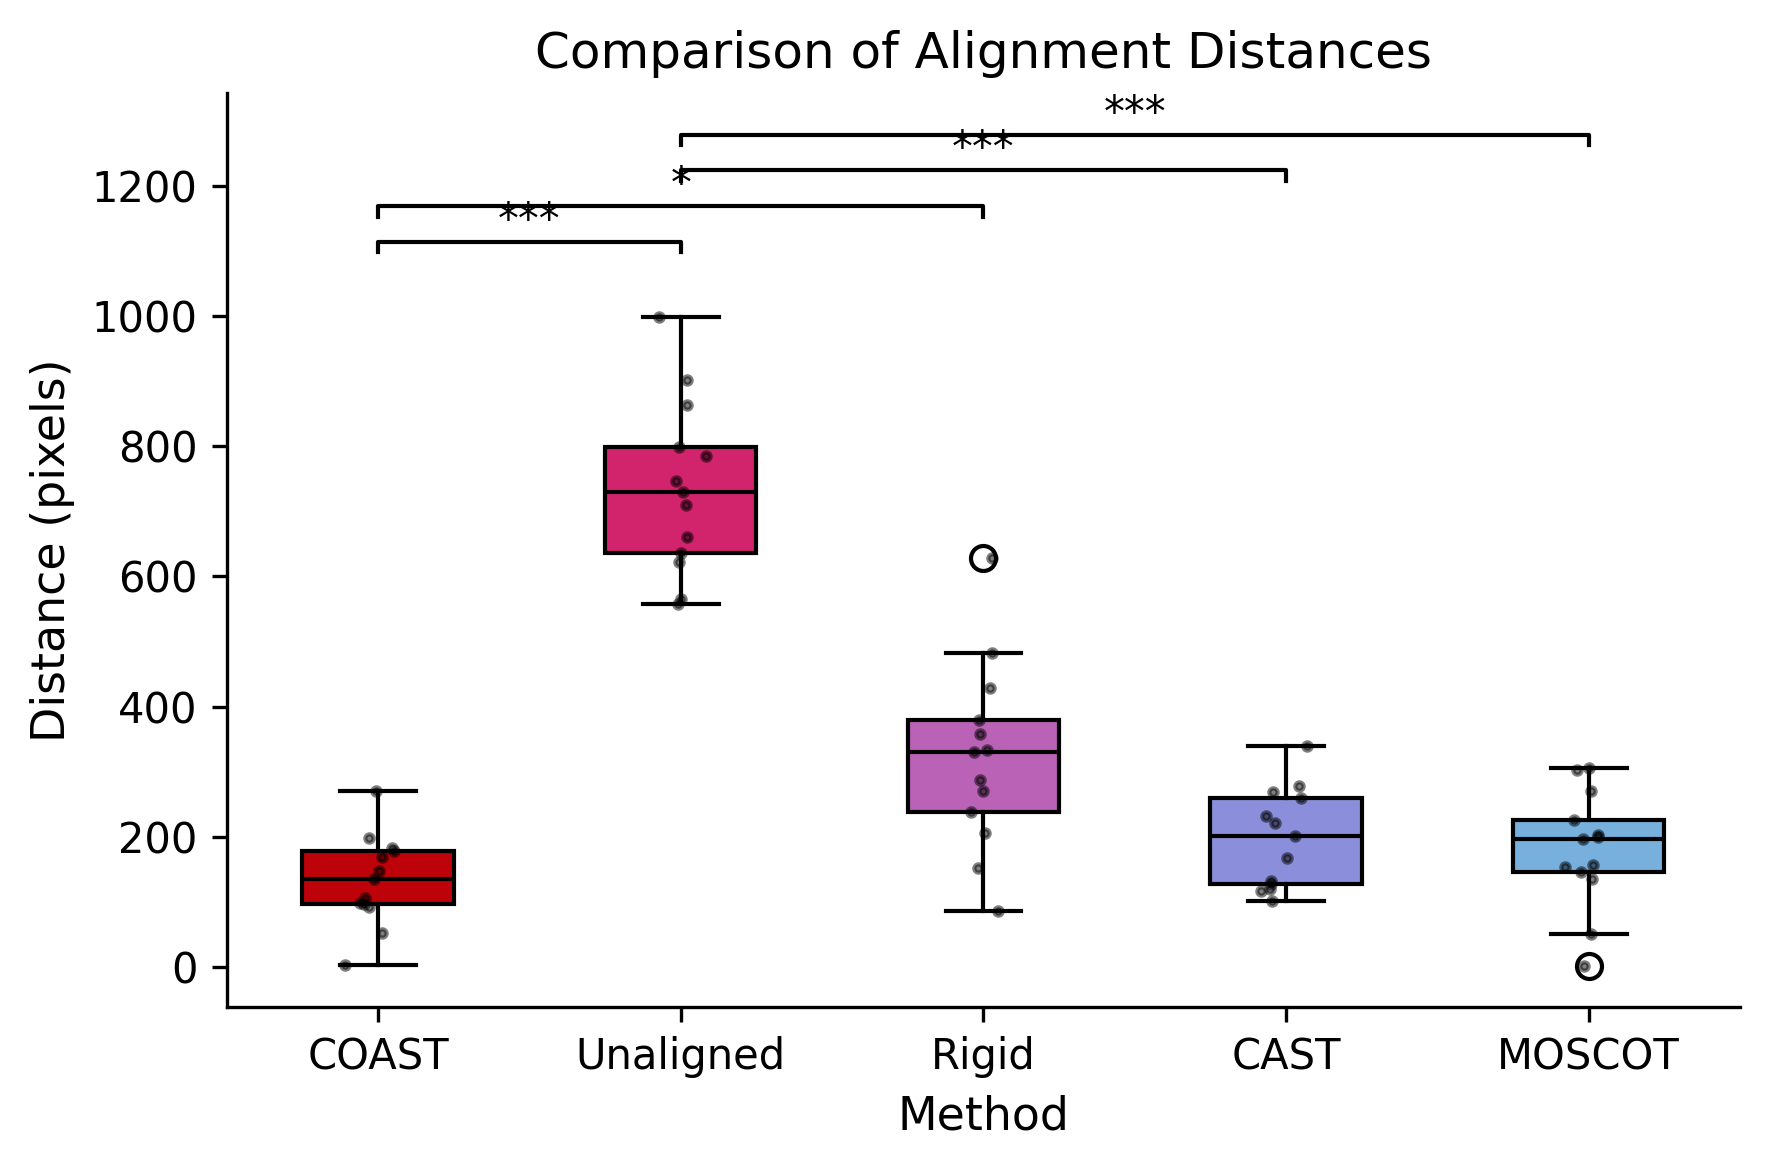

In [7]:
# distances
methods = ["COAST_distance", "Unalig_distance", "RA_distance", "CAST_distance", "MOSCOT_distance"]
labels = ["COAST", "Unaligned", "Rigid", "CAST", "MOSCOT"]
colors = ["#be020a", "#d2246c", "#b962b6", "#8b8fdb", "#77afdd"]
data = [landmarks_clean[m] for m in methods]

shapiro_results = [stats.shapiro(landmarks_clean[m]) for m in methods]
normal = all(r.pvalue > 0.05 for r in shapiro_results)

# choose test
if normal:
    stat, p_value = stats.f_oneway(*data)
    test_used = "One-way ANOVA"
else:
    stat, p_value = stats.kruskal(*data)
    test_used = "Kruskal-Wallis Test"

print(f"{test_used}: p={p_value:.5f}")  # original
print(f"Overall p-value: {p_value:.5f}")  # <-- added line

# post-hoc test: Dunn's (for Kruskal-Wallis)
posthoc = sp.posthoc_dunn([landmarks_clean[m] for m in methods], p_adjust='bonferroni')
posthoc.index = labels
posthoc.columns = labels

# boxplot
plt.figure(figsize=(6,4), dpi=300)
box = plt.boxplot(data, patch_artist=True, labels=labels, widths=0.5,
                  medianprops=dict(color="black"),
                  boxprops=dict(linewidth=1.0), 
                  whiskerprops=dict(linewidth=1.0),
                  capprops=dict(linewidth=1.0))

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

for i, (y, color) in enumerate(zip(data, colors)):
    x = np.random.normal(i+1, 0.04, size=len(y))
    plt.plot(x, y, 'o', color='black', alpha=0.5, markersize=2)

# significance stars
def add_sig_line(x1, x2, y, h, p_val, fs=10):
    """Add significance line between box x1 and x2 at height y"""
    sig = ""
    if p_val < 0.001:
        sig = '***'
    elif p_val < 0.01:
        sig = '**'
    elif p_val < 0.05:
        sig = '*'
    if sig:
        plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, color='black')
        plt.text((x1 + x2) * 0.5, y + h + 0.002, sig, ha='center', va='bottom', color='black', fontsize=fs)

y_max = max([max(d) for d in data]) * 1.1
step = (y_max / 20)
i = 0
for (a, b) in itertools.combinations(range(len(labels)), 2):
    p_val = posthoc.iloc[a, b]
    if p_val < 0.05:
        add_sig_line(a+1, b+1, y_max + i*step, step*0.3, p_val)
        i += 1

plt.title("Comparison of Alignment Distances", fontsize=12)
plt.ylabel("Distance (pixels)", fontsize=11)
plt.xlabel("Method", fontsize=11)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


In [8]:
# fix index 
landmarks_clean.index = [f'Pt-{i}' for i in range(len(landmarks_clean))]

#### Barplot of individual landmark distances per method

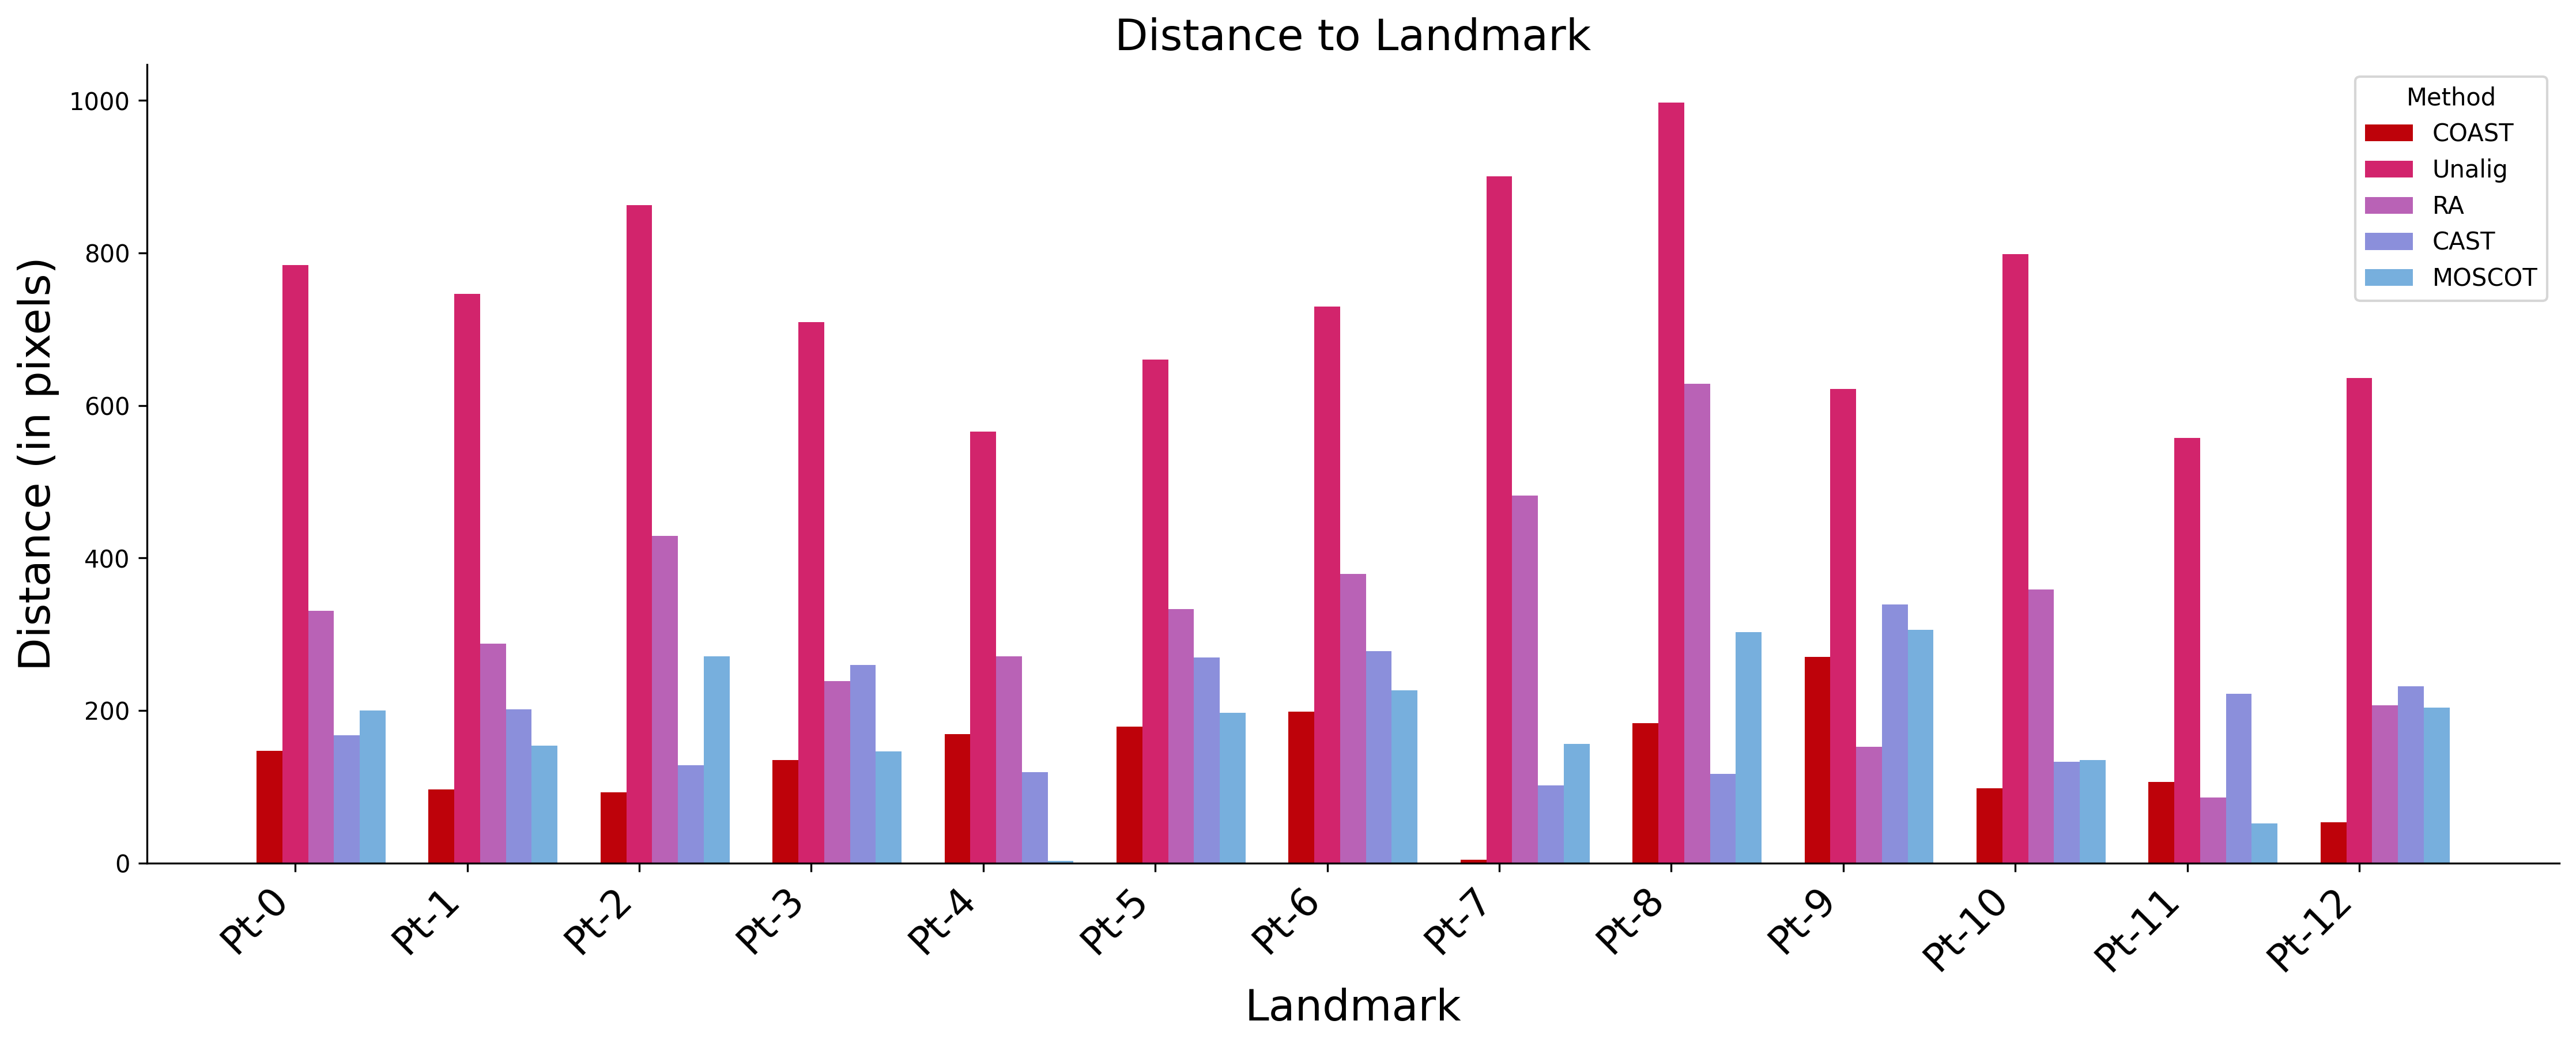

In [9]:
landmarks_clean['Point'] = landmarks_clean.index
df_melted = landmarks_clean.melt(id_vars='Point', var_name='Distance Type', value_name='Distance')

color_mapping = {
    "COAST_distance": "#be020a",
    "Unalig_distance": "#d2246c",  
    "RA_distance": "#b962b6",
    "CAST_distance": "#8b8fdb",
    "MOSCOT_distance": "#77afdd"
}

points = df_melted["Point"].unique()
distance_types = df_melted["Distance Type"].unique()

bar_width = 0.15
bar_positions = np.arange(len(points))

# fig
plt.figure(figsize=(18, 6), dpi=300)

for i, dist_type in enumerate(distance_types):
    subset = df_melted[df_melted["Distance Type"] == dist_type]
    plt.bar(bar_positions + i * bar_width, 
            subset["Distance"], 
            width=bar_width, 
            label=dist_type.split('_')[0],  # Clean label
            color=color_mapping[dist_type])

plt.xticks(bar_positions + bar_width, points, rotation=45, ha="right", fontsize=16)
plt.xlabel("Landmark", fontsize=18)
plt.ylabel("Distance (in pixels)", fontsize=18)
plt.title("Distance to Landmark", fontsize=18)
plt.legend(title="Method")

ax = plt.gca()  # Get current axis
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Show plot
plt.show()


#### Calculate and print median, max, and min for each method

In [10]:
columns = [
    "COAST_distance",
    "Unalig_distance",
    "RA_distance",
    "CAST_distance",
    "MOSCOT_distance",
]

for col in columns:
    median_val = landmarks_clean[col].median()
    max_val = landmarks_clean[col].max()
    min_val = landmarks_clean[col].min()
    
    print(f"{col} - Median: {median_val:.2f}, Max: {max_val:.2f}, Min: {min_val:.2f}")

COAST_distance - Median: 135.29, Max: 270.27, Min: 4.16
Unalig_distance - Median: 729.94, Max: 997.47, Min: 557.56
RA_distance - Median: 330.72, Max: 628.43, Min: 85.90
CAST_distance - Median: 201.76, Max: 339.20, Min: 101.50
MOSCOT_distance - Median: 197.31, Max: 305.76, Min: 2.46
